In [1]:
from PIL import Image
import inferless
import torch
import cv2
from diffusers import ControlNetModel, AutoPipelineForImage2Image
from diffusers.utils import load_image
import numpy as np
import base64


In [2]:
controlnet = ControlNetModel.from_pretrained(
            "diffusers/controlnet-depth-sdxl-1.0-small", # Smaller Depth ControlNet model
            torch_dtype=torch.float16,
            variant="fp16", 
            use_safetensors=True
        ).to("cuda")

pipeline = AutoPipelineForImage2Image.from_pretrained(
            "stabilityai/sdxl-turbo", # Faster Turbo model
            controlnet=controlnet,
            torch_dtype = torch.float16,
            variant = "fp16",
            use_safetensors=True
        ).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:

def preprocess_img(img: Image, res: tuple[int, int] = (1024, 1024)):

        """Preprocesses the input image: Load, Grayscale, Resize, CLAHE, Denoise, Sharpen, Convert to RGB."""
        kernel = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

        img = img.convert("L")
        img_np = np.array(img)

        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        contrast_img = clahe.apply(img_np)

        # Denoise the image first
        denoised_img = cv2.fastNlMeansDenoising(contrast_img, h=7) # Denoising strength
        
        # Sharpen the denoised image
        sharpened_img = cv2.filter2D(denoised_img, -1, kernel) 

        final = Image.fromarray(sharpened_img)
        # Convert final grayscale image to RGB for the pipeline input
        return final.convert("RGB")

def encode_base64(image: Image.Image, image_format: str = "PNG") -> str:
    """
    Encode a PIL image to a base64 string.

    Parameters:
        image (Image.Image): The PIL image to encode.
        image_format (str): Image format to use ("PNG", "JPEG", etc.)

    Returns:
        str: Base64-encoded image string.
    """
    buffered = BytesIO()
    image.save(buffered, format=image_format)

    img64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    if img64 is None:
        raise TypeError("Please check this goddam function")
    
    return img64 


In [2]:
def infer(url):
    img = load_image(url).resize((1024, 1024), Image.LANCZOS)
    control_image = preprocess_img(img)

    prompts = [
        "Photorealistic portrait of a bald cute asleep newborn baby, closed eyes, soft light, DSLR, 85mm lens",
    #   "Beautiful bald asleep newborn baby in a cradle, wearing a soft blue baby cap, warm diffuse lighting, natural tones",
        "Peaceful sleeping newborn baby, bald, close-up with detailed skin texture, photorealistic, pink skin, shallow depth of field",
        "Portrait of a sleeping newborn baby with closed eyes, resting peacefully in a soft womb-like environment, warm tones, detailed baby hands"
    ]

    negative_prompt = "hair, deformed, fingers, sad, ugly, disgusting, uncanny, blurry, grainy, monochrome, duplicate, artifact, watermark, text"

    num_inference_steps = [5, 4, 2]
    controlnet_conditioning_scale = [.3,.2,.12]
    guidance = [1,2,1]

    # Optional: set different generators for reproducibility
    seeds = [43, 44, 45]
    generators = [torch.manual_seed(seed) for seed in seeds]

    # Run batch if your pipeline supports it
    output_images = []

    assert len(prompts) == len(num_inference_steps) == len(controlnet_conditioning_scale) == len(guidance) == len(generators), "Input lists must have the same length"
    assert type(img) == Image.Image, "Input image must be a PIL Image"


    with torch.inference_mode():
        for i in range(len(prompts)):
            tmp = pipeline(
                image=img,
                prompt= prompts[i],
                negative_prompt=[negative_prompt],
                control_image=control_image,
                guidance_scale=guidance[i],
                controlnet_conditioning_scale=controlnet_conditioning_scale[i],
                num_inference_steps=num_inference_steps[i],
                generator=generators[i],
                height=1024,
                width=1024
            ).images
            output_images.append(tmp[0])
            del tmp
            torch.cuda.empty_cache()
            
        
            

    # Convert to base64
    output_images = [encode_base64(image) for image in output_images]
    return {"images": output_images}

In [3]:
torch.cuda.empty_cache()
imgs = infer("https://raw.githubusercontent.com/josho201/3dUltra/refs/heads/main/imgs/test2.png")

NameError: name 'torch' is not defined

In [26]:

from IPython.display import display

def show_base64_image_notebook(base64_str: str):
    if ',' in base64_str:
        base64_str = base64_str.split(',')[1]
    
    image_data = base64.b64decode(base64_str)
    image = Image.open(BytesIO(image_data))
    display(image)
    


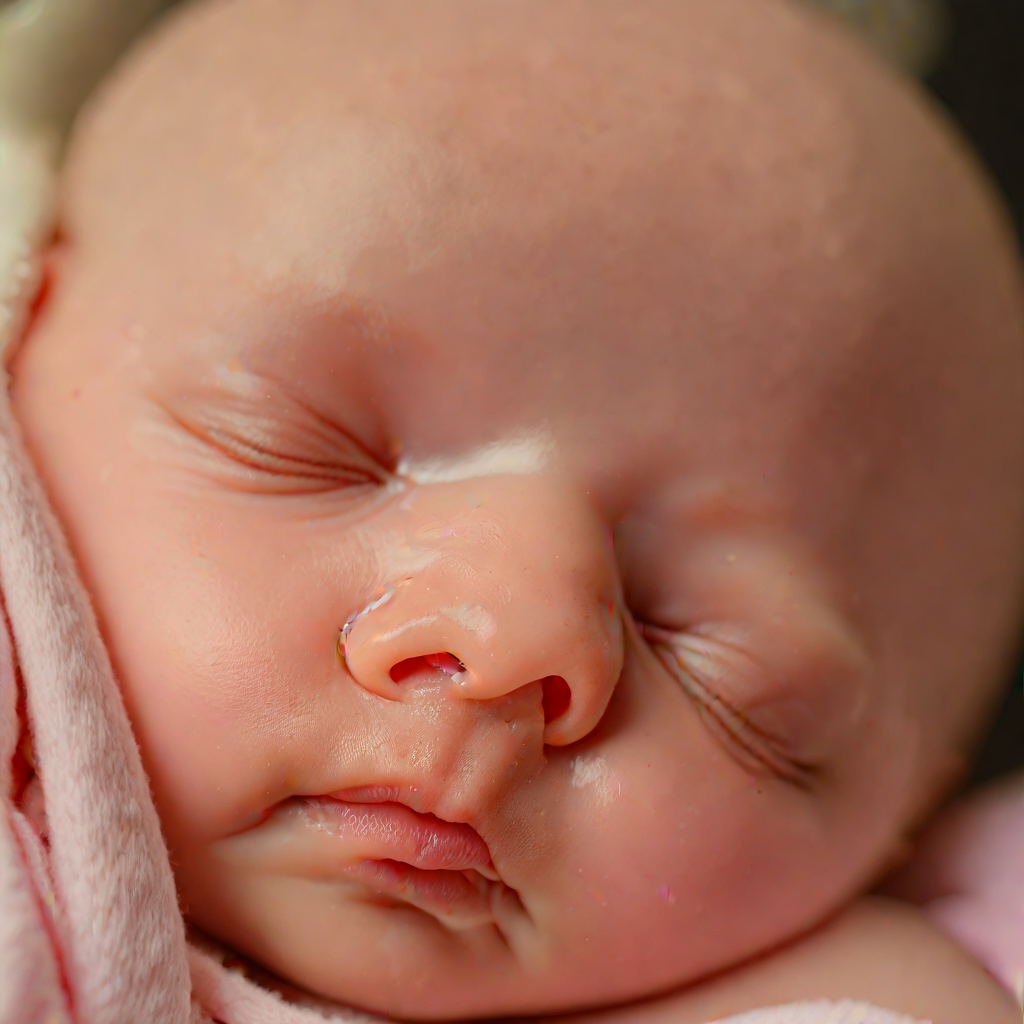

In [27]:

show_base64_image_notebook(imgs['images'][1])